In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import cv2

In [181]:
# loading the data file
data=pd.read_csv('./test.txt', header=None)

In [182]:
# (no_of_images,(28*28)pixels)
data.shape

(10740, 784)

In [183]:
# Normalize each pixel value from range[0,255] to range[0,1]
norm_data =data/255.0

In [184]:
# flattening the pixels into a 1D vector
flat_data = norm_data.values.reshape(norm_data.shape[0],-1)

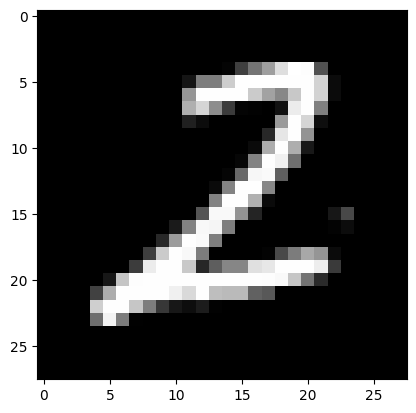

In [185]:
plt.imshow(flat_data[90].reshape(28, 28), cmap='gray');
plt.show()


In [186]:
def apply_blur(image, kernal_size=(3,3)):
  blurred_img = cv2.GaussianBlur(image,kernal_size,0)
  blurred_img = cv2.blur(blurred_img,kernal_size)
  return blurred_img

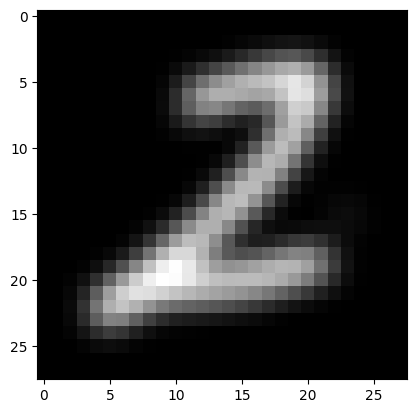

In [187]:
plt.imshow(apply_blur(flat_data[90].reshape(28, 28)), cmap='gray')

In [189]:
transformed_imgs = []

for image in range(flat_data.shape[0]):
  blurred_image = apply_blur(flat_data[image].reshape(28, 28))
  transformed_imgs.append(blurred_image.reshape(-1))

transformed_imgs = np.array(transformed_imgs)

In [190]:
transformed_imgs.shape

(10740, 784)

In [217]:
# dimensionality reduction where 90% data is retained
pca = PCA(n_components=0.99)
reduced_data = pca.fit_transform(transformed_imgs)

In [218]:
reduced_data.shape

(10740, 65)

In [129]:
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(reduced_data)

In [219]:
ms = MinMaxScaler(feature_range=(1,1000))
scaled_data = ms.fit_transform(reduced_data)

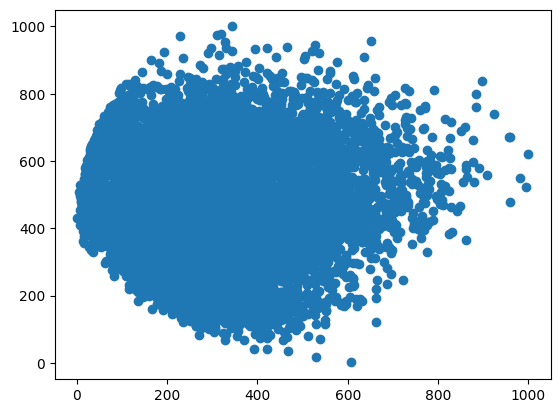

In [220]:
plt.scatter(scaled_data[:,0], scaled_data[:,1])

In [221]:
#Visualising high-dimensional data into lower dimensional (2D)
tsne = TSNE(n_components=2, n_iter=5000, n_iter_without_progress=250, perplexity=20, early_exaggeration=25)
lower_dimension_data = tsne.fit_transform(scaled_data)

In [223]:
lower_dimension_data.shape

(10740, 2)

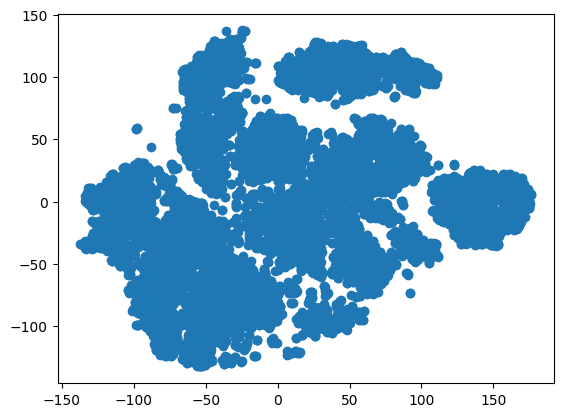

In [224]:
plt.scatter(lower_dimension_data[:,0], lower_dimension_data[:,1])

In [225]:
def generateRandomKCentroids(data,k):
  random_indices = np.random.randint(0,data.shape[0], size=(k,))
  centroids = data[random_indices, :]
  return centroids

In [226]:
def assignClusters(data, centroids):
  distances = np.linalg.norm(data[:,np.newaxis,:] - centroids, axis=2)
  clusters = np.argmin(distances, axis=1)
  return clusters

In [227]:
generateRandomKCentroids(lower_dimension_data,10)

array([[  66.63442   ,   95.116035  ],
       [ 127.31164   ,    0.94790506],
       [-113.68432   ,   16.35037   ],
       [ -70.37065   , -110.71198   ],
       [-101.45628   ,   23.696404  ],
       [ -36.81618   ,  -85.705986  ],
       [ -13.838704  ,  -18.413033  ],
       [  10.115763  ,  108.04273   ],
       [  -1.3142494 ,  -84.09107   ],
       [  26.999418  ,    4.029663  ]], dtype=float32)

In [228]:
data = lower_dimension_data

In [229]:
centroids = generateRandomKCentroids(data, 10)
clusters = assignClusters(data, centroids)

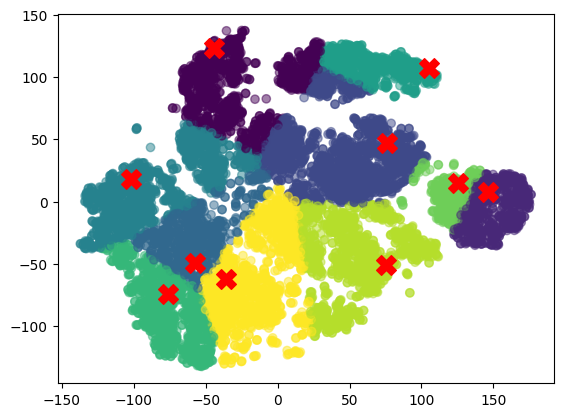

In [230]:
plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', alpha=0.5, label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

In [231]:
def updateCentroids(data, clusters, numClusters):
    newCentroids = np.array([data[clusters == k].mean(axis=0) for k in range(numClusters)])
    return newCentroids

In [232]:
updateCentroids(data, clusters, 10)

array([[-26.528748 ,  92.71262  ],
       [150.31026  ,  -5.7712784],
       [ 44.454216 ,  39.080643 ],
       [-56.946774 , -25.74098  ],
       [-82.468956 ,  12.753227 ],
       [ 67.878624 , 107.845764 ],
       [-76.525406 , -86.50173  ],
       [119.57403  ,   5.292695 ],
       [ 54.860394 , -45.460915 ],
       [-14.000896 , -61.130325 ]], dtype=float32)

In [233]:
def reinitializeEmptyClusters(data, clusters, centroids):
  unique_clusters, counts = np.unique(clusters, return_counts=True)

  # Find empty clusters
  empty_clusters = unique_clusters[counts == 0]

  # Reinitialize empty clusters
  for empty_cluster in empty_clusters:
    empty_cluster_index = np.random.randint(0, data.shape[0])
    centroids[empty_cluster] = data[empty_cluster_index]

  return centroids


In [234]:
def cal_inertia(data, centroids, clusters):
  inertia = 0
  for i in range(len(centroids)):
    clusters_points = data[clusters == i]
    distances = np.sum((clusters_points - centroids[i])**2, axis=1)
    inertia += np.sum(distances)
  return inertia

In [235]:
def kMeans(data, numClusters, maxIterations=350):
  centroids = generateRandomKCentroids(data, numClusters)

  for i in range(maxIterations):
    clusters = assignClusters(data, centroids)
    newCentroids = updateCentroids(data, clusters, numClusters)
    centroids = reinitializeEmptyClusters(data, clusters, newCentroids)

    if np.all(centroids == newCentroids):
      break

    centroids = newCentroids

  return clusters, centroids

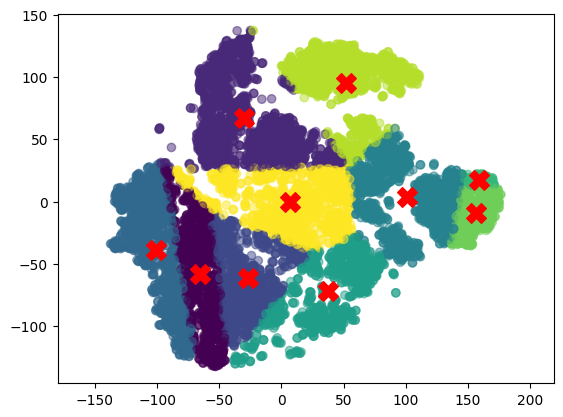

In [236]:
final_clusters, final_centroids = kMeans(data, 10,500)

plt.scatter(data[:, 0], data[:, 1], c=final_clusters, cmap='viridis', alpha=0.5, label='Data Points')
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.axis('equal')  # Set equal aspect ratio for the x and y axes
plt.show()


In [237]:
inertia_values=[]
for k in range(2, 21, 2):
    final_clusters, final_centroids = kMeans(data, k)
    inertia = cal_inertia(data, final_centroids, final_clusters)
    print(f'Number of Clusters: {k}, Inertia: {inertia}')
    inertia_values.append(inertia)

Number of Clusters: 2, Inertia: 76634348.0
Number of Clusters: 4, Inertia: 36095426.5
Number of Clusters: 6, Inertia: 25325163.625
Number of Clusters: 8, Inertia: 28122273.4453125
Number of Clusters: 10, Inertia: 14287791.96875
Number of Clusters: 12, Inertia: 12305763.1171875
Number of Clusters: 14, Inertia: 15904707.42578125
Number of Clusters: 16, Inertia: 9473263.2265625
Number of Clusters: 18, Inertia: 7006338.67578125
Number of Clusters: 20, Inertia: 6349292.725708008


In [238]:
k_values = range(2, 21, 2)


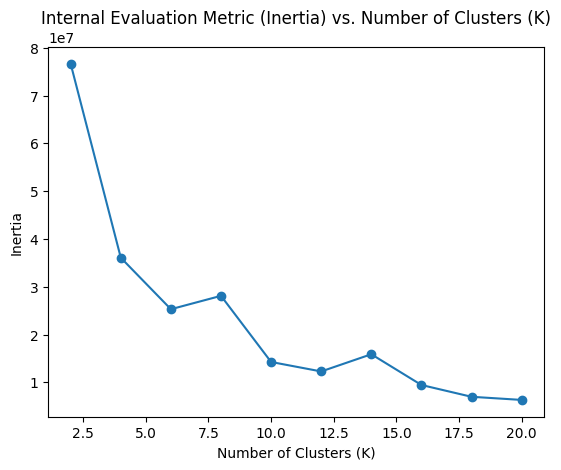

In [239]:
plt.plot(k_values, inertia_values, marker='o')
plt.title('Internal Evaluation Metric (Inertia) vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

In [240]:
def calculate_silhouette_score(data, k_values):
    silhouette_scores = []

    for k in k_values:
        final_clusters, _ = kMeans(data, k)
        silhouette = silhouette_score(data, final_clusters)
        silhouette_scores.append(silhouette)

    return silhouette_scores

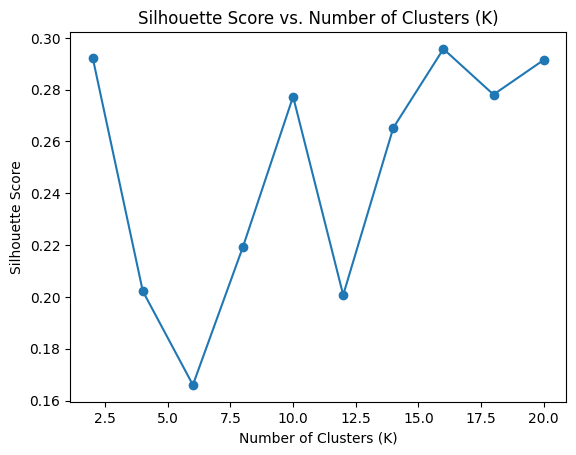

In [241]:
silhouette_scores = calculate_silhouette_score(data, k_values)

# Plot the silhouette scores against the number of clusters (K)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()